In [3]:
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()
pd.options.display.float_format = '{:.2f}'.format

In [5]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [6]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  #path= "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
  data_path= "/content/gdrive/MyDrive/Symbol_to_Symbol/ANN_dataset/rawData/rawData_mod"
  output_data_path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset/trainingData"
  model_path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset/trainedModel"
else: path = os.getcwd()

In [7]:
#data_path=os.getcwd()+"/ANN_dataset/rawData/rawData_mod"

#output_data_path=os.getcwd()+"/ANN_dataset/trainingData"

#model_path=os.getcwd()+"/models"

distances=list(range(1,26))
print(distances)
trainingProp=0.80
ns=50 # number of samples
centers=[[-3,3],[-1,3],[1,3],[3,3],[-3,1],[-1,1],[1,1],[3,1],[-3,-1],[-1,-1],[1,-1],[3,-1],[-3,-3],[-1,-3],[1,-3],[3,-3]]
selCP=[1,7,10,15]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [8]:
def L2dist(a,b):
    return math.sqrt(math.pow(a[0]-b[0],2)+math.pow(a[1]-b[1],2))

In [9]:
F=[]
for ll in distances:
    filename=data_path+"/consts_"+str(ll)+"span_mod.csv"
    df = pd.read_csv(filename)
    for i in range(1,ns+1):
        df_aux=df[df["Sample_Id"]==i]
        real=df_aux["Real"]
        imag=df_aux["Imag"]
        data_aux=list(zip(real,imag))
        gmm = GaussianMixture(n_components=16, random_state=0, init_params='kmeans', means_init=centers).fit(data_aux)
        mus=gmm.means_
        sigmas=gmm.covariances_
        features=[ll*80]
        for jj in selCP:
            j=centers[jj-1]
            mindist=None
            k_inc=None
            for k in range(16):
                d=L2dist(mus[k],j)
                if mindist is None or mindist>d:
                    mindist=d
                    k_inc=k
            covmat=np.concatenate(list(sigmas[k_inc])).ravel().tolist()
            features = [*features, *mus[k_inc], *covmat]
        F.append(features)   
# F = sample
# with 24 features 

In [ ]:
R=np.random.permutation(len(F))
nt=math.ceil(len(F)*trainingProp)
rows_training=R[0:nt]
rows_testing=R[(nt):(len(F)+1)]

In [ ]:
header=['dist']
for j in selCP:
    header=[*header,*['mu_r_'+str(j),'mu_i_'+str(j),'sigma_rr_'+str(j),'sigma_ri_'+str(j),'sigma_ir_'+str(j),'sigma_ii_'+str(j)]]
    
F_training=[F[f] for f in rows_training]
F_testing=[F[f] for f in rows_testing]

DF_training=pd.DataFrame(F_training)
DF_training.columns=header
DF_training.to_csv(output_data_path+'/training_data_DNN.csv', index=False)

DF_testing=pd.DataFrame(F_testing)
DF_testing.columns=header
DF_testing.to_csv(output_data_path+'/testing_data_DNN.csv', index=False)

In [ ]:

df=pd.read_csv(output_data_path+'/training_data_DNN.csv')

colnames=df.columns[1:25]
# Target variable and train set
X=df.iloc[:,1:25]
#print(X.shape)
#print(X.columns)
Y=df.iloc[:,0].to_numpy().reshape(-1,1)
#print(Y.shape)
#print(Y.columns)

#labels=[int(i) for i in df.iloc[:,0]]

sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
X_train = sc_input.fit_transform(X)
Y_train = sc_output.fit_transform(Y)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(24, input_dim = 24, activation = 'tanh'))
    model.add(Dense(12,activation='tanh'))
    model.add(Dense(6,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Streaming output truncated to the last 5000 lines.
32/32 [==============================] - 0s 1ms/step - loss: 8.6128e-05
Epoch 2502/5000
32/32 [==============================] - 0s 1ms/step - loss: 1.0609e-04
Epoch 2503/5000
32/32 [==============================] - 0s 1ms/step - loss: 8.6768e-05
Epoch 2504/5000
32/32 [==============================] - 0s 1ms/step - loss: 9.7259e-05
Epoch 2505/5000
32/32 [==============================] - 0s 1ms/step - loss: 8.7093e-05
Epoch 2506/5000
32/32 [==============================] - 0s 1ms/step - loss: 8.6641e-05
Epoch 2507/5000
32/32 [==============================] - 0s 1ms/step - loss: 9.2499e-05
Epoch 2508/5000
32/32 [==============================] - 0s 1ms/step - loss: 9.2404e-05
Epoch 2509/5000
32/32 [==============================] - 0s 1ms/step - loss: 8.7315e-05
Epoch 2510/5000
32/32 [==============================] - 0s 1ms/step - loss: 9.2947e-05
Epoch 2511/5000
32/32 [==============================] - 0s 1ms/step - loss: 9.6647e-

In [ ]:
df=DF_testing
colnames=df.columns[1:25]
X=df.iloc[:,1:25]
Y=df.iloc[:,0].to_numpy().reshape(-1,1)
X_test = sc_input.transform(X)
Y_test = sc_output.transform(Y)

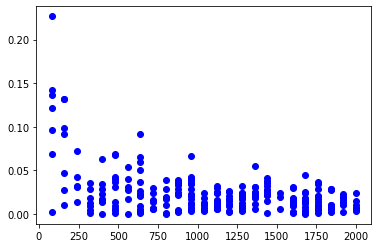

In [ ]:
start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
#Y_test_pred=model_ann.predict(X_test)
time_eval_ann=time.time()-start_time

real=list(list(zip(*Y_test))[0])

#real=list(map(list, zip(*Y_train)))
pred=list(Y_test_pred)

dist_min=sc_output.data_min_[0]
dist_max=sc_output.data_max_[0]

real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real))
real_abs=[int(np.round(i)) for i in real_abs]
#print(real_abs)
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred))
#print(pred_abs)

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))

res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
res.to_csv("results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()

In [ ]:
R=[]
for ll in distances: 
    res_mean=np.mean(res[res["dist"]==ll*80])
    res_std=np.std(res[res["dist"]==ll*80])
    R.append([res_mean["dist"],res_mean["pred"],res_std["pred"]])
R=pd.DataFrame(R)
R.columns=["dist","mean","std"]

In [ ]:
R.to_csv(model_path+"/reference.csv", index=False)
json_model = model_ann.model.to_json()
open(model_path+"/model_ann_architecture.json", 'w').write(json_model)
model_ann.model.save_weights(model_path+'/model_ann_weights.h5', overwrite=True)
joblib.dump(sc_input, model_path+'/scaler_input.joblib')
joblib.dump(sc_output, model_path+'/scaler_output.joblib')

['/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset/trainedModel/scaler_output.joblib']

In [ ]:
print(sc_input.data_min_)
print(sc_input.data_max_)


[-3.03670163e+00  2.91801267e+00  3.86233951e-03 -1.50244735e-02
 -1.50244735e-02  3.50405519e-03  9.46312566e-01  9.69838145e-01
  2.86608720e-03 -1.38727078e-02 -1.38727078e-02  2.67208245e-03
 -1.02006083e+00 -1.02696373e+00  2.86323312e-03 -3.93380664e-03
 -3.93380664e-03  2.70032452e-03  9.76658940e-01 -3.01918878e+00
  3.53056890e-03 -1.06544279e-02 -1.06544279e-02  2.58932458e-03]
[-2.934883    3.00183715  0.12617059  0.00729831  0.00729831  0.12351432
  1.01944524  1.05218133  0.10524003  0.00310027  0.00310027  0.12613898
 -0.95590205 -0.96450322  0.1251427   0.02316845  0.02316845  0.10861225
  1.0336819  -2.92784348  0.09748311  0.00780845  0.00780845  0.09217364]


In [ ]:
X_test

array([[0.2153114 , 0.91333928, 0.15680262, ..., 0.79418786, 0.79418786,
        0.24845311],
       [0.52831933, 0.47630105, 0.38124716, ..., 0.53965251, 0.53965251,
        0.51741815],
       [0.47014226, 0.52181687, 0.33037328, ..., 0.76025827, 0.76025827,
        0.4798837 ],
       ...,
       [0.52658767, 0.44467101, 0.36917939, ..., 0.85067798, 0.85067798,
        0.52922795],
       [0.76385377, 0.22468832, 0.70462843, ..., 0.45594019, 0.45594019,
        0.84048627],
       [0.38912343, 0.57730815, 0.26077732, ..., 0.85621162, 0.85621162,
        0.41548351]])